In [2]:
#### 1.Loading_data.R
### 1)Read cluster resaults
Cluster.20200201.V7.Tumor <- readRDS("/data8t_4/JH/MyJobs/NormalCancer_TCGA_V2/Cluster.20200201.V7.Tumor.rds")
cutree.res <- Cluster.20200201.V7.Tumor$cutree.res
dynamicColors <- Cluster.20200201.V7.Tumor$dynamicColors
Cluster.df <- cbind(cutree.res,dynamicColors) 
Cluster.df <- as.data.frame(Cluster.df)
Cluster.df$rownames <- rownames(Cluster.df)
hclust.Res <- Cluster.20200201.V7.Tumor$hclust.Res

### 2) DNA methylation mergedMethyl_27K_450K_dataset
COAD_PanCancerAtlas_Publish_mergedMethyl_27K_450K_dataset <- readRDS("/data8t_4/JH/MyJobs/Read_dataset/TCGA_PanCancerAtlas_Publications/DNA_Methylation_Merged_27K_450K_Only/COAD_PanCancerAtlas_Publish_mergedMethyl_27K_450K_dataset.rds")


[1] 22601   522


   FALSE     TRUE 
11790640     7082 

[1] 21418   522

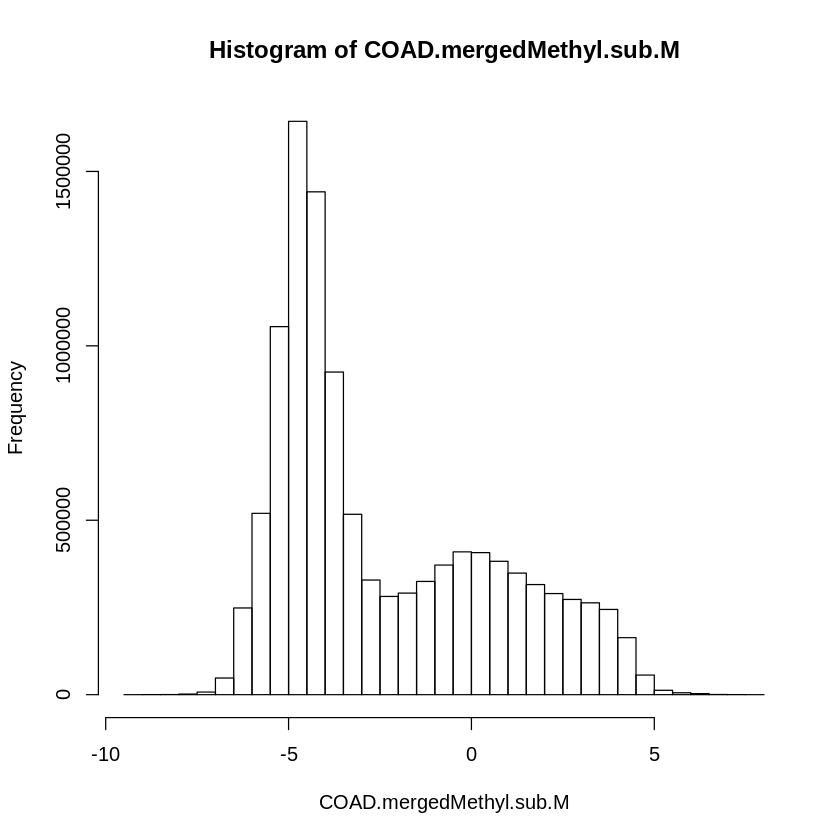

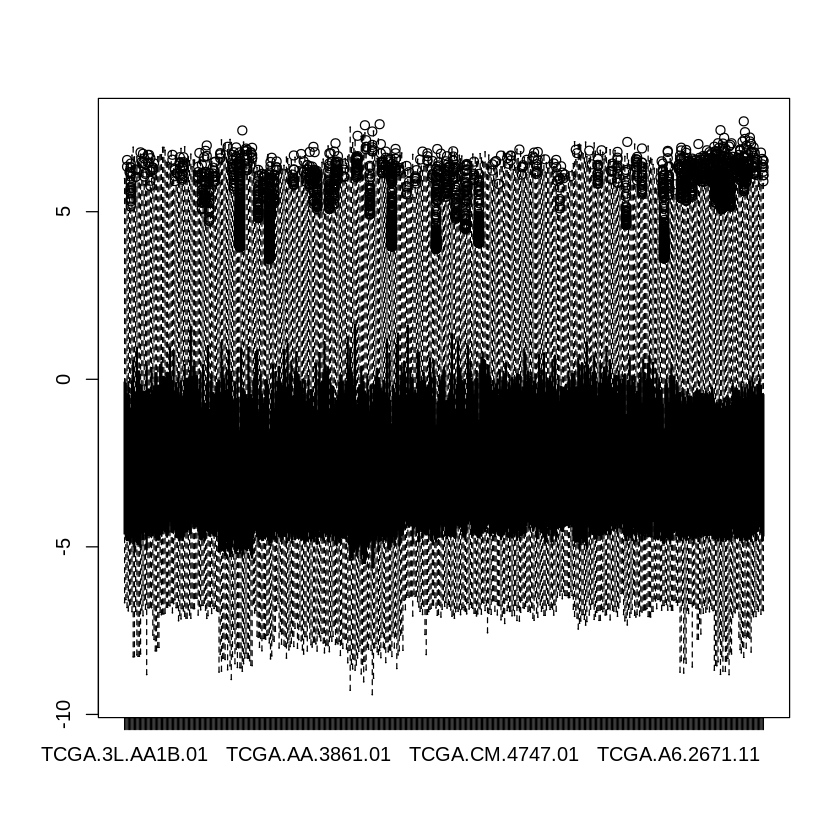

In [5]:
### 2.GGplot_COAD_DNA_methylationmergedMethyl_27K_450K.R
# BiocManager::install("lumi")
COAD.mergedMethyl.27.450.mx <- COAD_PanCancerAtlas_Publish_mergedMethyl_27K_450K_dataset$COAD.mergedMethyl.27.450.mx
dim(COAD.mergedMethyl.27.450.mx)
table(is.na(COAD.mergedMethyl.27.450.mx))
## 1) remove rows contain NAs
COAD.mergedMethyl.sub <- COAD.mergedMethyl.27.450.mx[complete.cases(COAD.mergedMethyl.27.450.mx), ]
dim(COAD.mergedMethyl.sub)
## 2) Convert methylation Beta-value to M-value
library(lumi)
COAD.mergedMethyl.sub.M <- beta2m(COAD.mergedMethyl.sub)
hist(COAD.mergedMethyl.sub.M)
boxplot(COAD.mergedMethyl.sub.M)
#class(COAD.mergedMethyl.sub.M)
#COAD.mergedMethyl.sub.M[1:5,1:5]
## 3)Builed ExpressionSet
library(Biobase)
#table(Cluster.df$rownames %in% colnames(COAD.mergedMethyl.sub.M))
sampleID <- Cluster.df$rownames[Cluster.df$rownames %in% colnames(COAD.mergedMethyl.sub.M)]
Cluster.df.sub <- new("AnnotatedDataFrame",
                      data=Cluster.df[sampleID,])
COAD.methy.set <- ExpressionSet(assayData=COAD.mergedMethyl.sub.M[,sampleID],
                                phenoData=Cluster.df.sub)

## 4) Probe-wise differential methylation analysis
#https://www.bioconductor.org/packages/devel/workflows/vignettes/methylationArrayAnalysis/inst/doc/methylationArrayAnalysis.html
## Several Groups experiment design
library(limma)
#Cluster.df.sub@data$dynamicColors
f.meth <- factor(Cluster.df.sub@data$dynamicColors, levels=c("blue","brown","turquoise","yellow"))
design.meth <- model.matrix(~0+f.meth)
colnames(design.meth) <- c("blue","brown","turquoise","yellow")
# fit the linear model 
fit.meth <- lmFit(COAD.methy.set, design.meth)
contrast.matrix.methy <- makeContrasts(blue-(brown+turquoise), 
                                      brown-(blue+turquoise),
                                      turquoise-(brown+blue),
                                      levels=design.meth)
# fit the contrasts
fit.meth.2 <- contrasts.fit(fit.meth, contrast.matrix.methy)
fit.meth.2 <- eBayes(fit.meth.2)
# look at the numbers of DM CpGs at FDR < 0.05
#summary(decideTests(fit.meth.2))

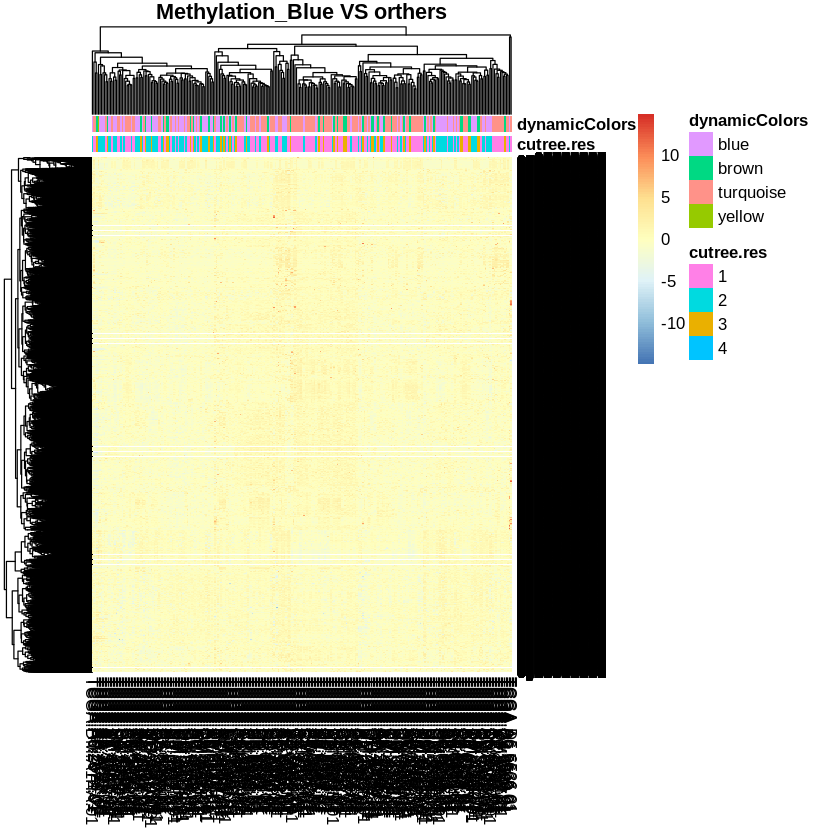

In [8]:
# get the table of results for the first contrast blue-(brown+turquoise)
adjPvalueCutoff <- 0.01
logFCcutoff <- log2(2)
number = Inf
DMPs.blue <- topTable(fit.meth.2, num=number, coef="blue - (brown + turquoise)")
DMPs.brown <- topTable(fit.meth.2, num=number, coef="brown - (blue + turquoise)")
DMPs.turquoise <- topTable(fit.meth.2, num=number, coef="turquoise - (brown + blue)")
#head(DMPs.blue)
## 5) Heatmap ploting
pheatmap::pheatmap(COAD.methy.set[rownames(DMPs.blue),],annotation_col = pData(COAD.methy.set)[,1:2],
                   main = "Methylation_Blue VS orthers", scale = "row")

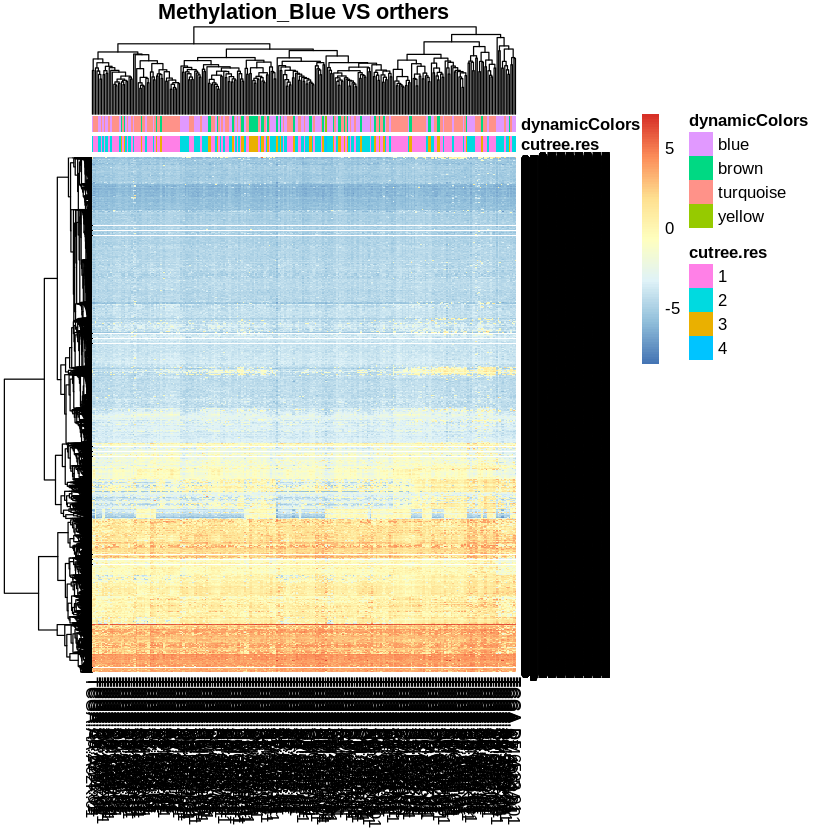

In [9]:
pheatmap::pheatmap(COAD.methy.set[rownames(DMPs.blue),],annotation_col = pData(COAD.methy.set)[,1:2],
                   main = "Methylation_Blue VS orthers")

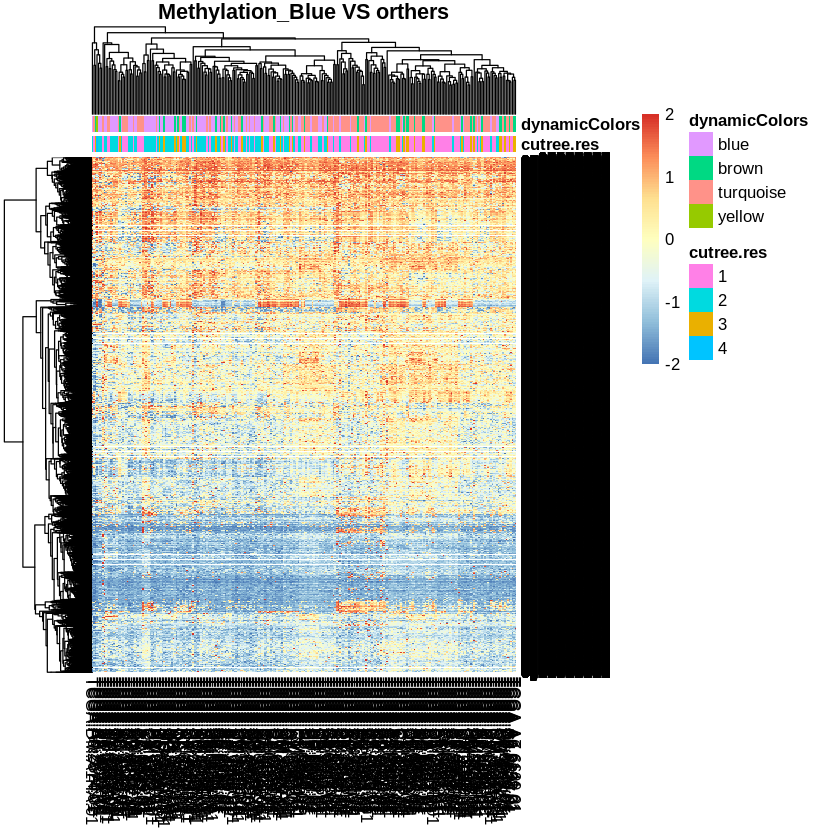

In [12]:
require(scales)
all <- exprs(COAD.methy.set)
all.2 <- apply(all, 1, rescale, to=c(-2,2))
pheatmap::pheatmap(t(all.2),annotation_col = pData(COAD.methy.set)[,1:2],
                   main = "Methylation_Blue VS orthers")